In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Pool
from itertools import product

In [7]:
%matplotlib inline

In [8]:
test = pd.read_csv('test.csv')
shop = pd.read_csv('shops.csv')
submission = pd.read_csv('sample_submission.csv')
sales = pd.read_csv('sales_train.csv')
item = pd.read_csv('items.csv')
item_category = pd.read_csv('item_categories.csv')

### Add missing item, shop id combination

In [9]:
cols = ['shop_id', 'item_id', 'date_block_num']
grid = []
for block_num in sales['date_block_num'].unique():
    shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[shops, items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = cols,dtype=np.int32)

### EDA

In [10]:
shop.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [11]:
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [12]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [13]:
item_category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


### Shop

In [14]:
shop.describe()

,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


In [15]:
item_category.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


In [16]:
item_category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [17]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [18]:
item.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [19]:
len(item.item_id.unique())

22170

In [20]:
len(item.item_category_id.unique())

84

### Combine data tables

In [21]:
df_main = sales.groupby(['date_block_num','shop_id','item_id']).agg(
        {
            'item_cnt_day': 'sum',
            'item_price': np.mean
        }).reset_index()

### Merge the grid to add missing shop_id/item_id combination and fill the values with zeros safely

If there was a sale it would have been in sales table. Since they are not no of sales in shopid/itemid combination is zero

In [22]:
df_main = pd.merge(grid, 
                   df_main, 
                   on=['date_block_num','shop_id','item_id'],
                   how='left').fillna(0)

In [23]:
df_main.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price
0,59,22154,0,1.0,999.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0


### Get item_category in df_main as it could be a great feature

In [24]:
df_main = pd.merge(df_main,
                   item,
                   on=['item_id'],
                   how='left')

In [25]:
df_main.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59


In [26]:
df_main.drop('item_name', inplace=True, axis=1)

In [27]:
df_main.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_category_id
0,59,22154,0,1.0,999.0,37
1,59,2552,0,0.0,0.0,58
2,59,2554,0,0.0,0.0,58
3,59,2555,0,0.0,0.0,56
4,59,2564,0,0.0,0.0,59


In [28]:
df_main.describe()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_category_id
count,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07
mean,3.118720e+01,1.130926e+04,1.497334e+01,3.342731e-01,1.166070e+02,4.491731e+01
std,1.734959e+01,6.209978e+03,9.495618e+00,3.417243e+00,6.584686e+02,1.510627e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+01,0.000000e+00,0.000000e+00
25%,1.600000e+01,5.976000e+03,7.000000e+00,0.000000e+00,0.000000e+00,3.700000e+01
50%,3.000000e+01,1.139100e+04,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+01
75%,4.600000e+01,1.660500e+04,2.300000e+01,0.000000e+00,0.000000e+00,5.500000e+01
max,5.900000e+01,2.216900e+04,3.300000e+01,2.253000e+03,3.079800e+05,8.300000e+01


In [31]:
df_main.shape

(10913850, 6)

In [32]:
df_main.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)

In [33]:
df_main.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_category_id
0,59,22154,0,1.0,999.0,37
1,59,2552,0,0.0,0.0,58
2,59,2554,0,0.0,0.0,58
3,59,2555,0,0.0,0.0,56
4,59,2564,0,0.0,0.0,59


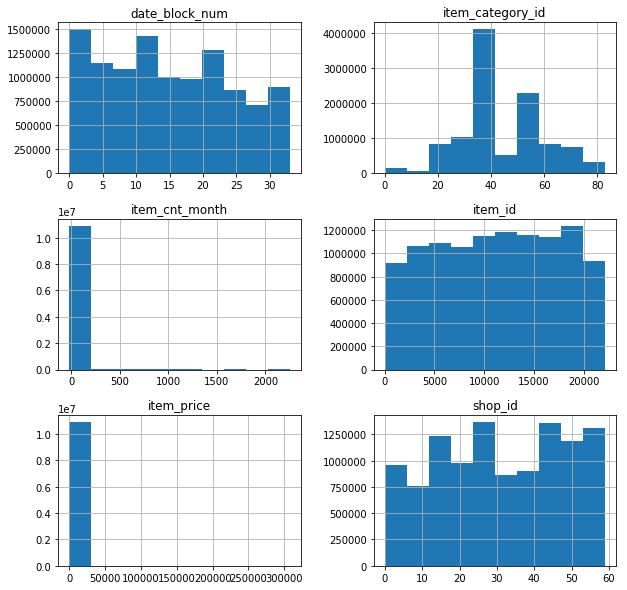

In [34]:
hist_plot = df_main.hist(figsize=(10, 10))

### Note the histogram above
* item_cnt_month: Mostlu range between 0-20, there are few which range from 500-3000
* we can get a better plot for item_cnt_month and item_price without the outlires
* item_category_id: Some item_category is more popular than others (we can have a look)

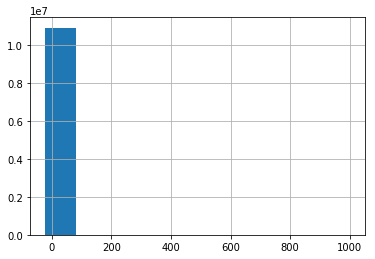

In [35]:
item_cnt = df_main[df_main.item_cnt_month<=1000]['item_cnt_month']
item_cnt_plot_without_outliers = item_cnt.hist()

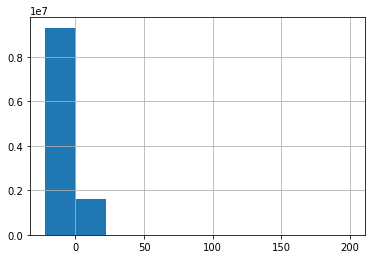

In [36]:
item_cnt = df_main[df_main.item_cnt_month<=200]['item_cnt_month']
item_cnt_plot_without_outliers = item_cnt.hist()

In [37]:
item_cnt.describe()

count    1.091350e+07
mean     3.206842e-01
std      1.953537e+00
min     -2.200000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+02
Name: item_cnt_month, dtype: float64

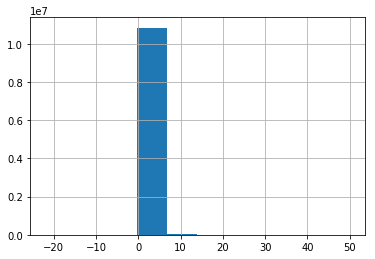

In [38]:
item_cnt = df_main[df_main.item_cnt_month<=50]['item_cnt_month']
item_cnt_plot_without_outliers = item_cnt.hist()

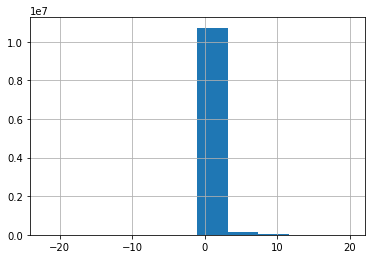

In [39]:
item_cnt = df_main[df_main.item_cnt_month<=20]['item_cnt_month']
item_cnt_plot_without_outliers = item_cnt.hist()

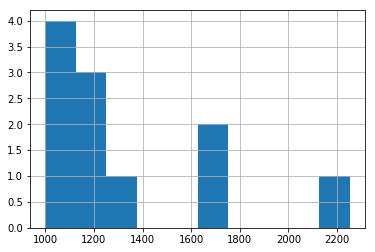

In [40]:
item_cnt = df_main[df_main.item_cnt_month>=1000]['item_cnt_month']
item_cnt_plot_without_outliers = item_cnt.hist()

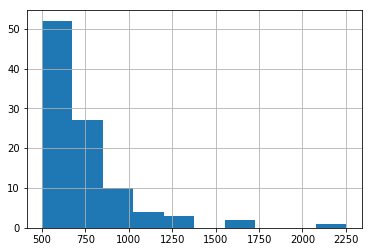

In [41]:
item_cnt = df_main[df_main.item_cnt_month>=500]['item_cnt_month']
item_cnt_plot_without_outliers = item_cnt.hist()

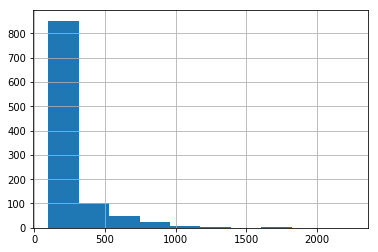

In [42]:
item_cnt = df_main[df_main.item_cnt_month>=100]['item_cnt_month']
item_cnt_plot_without_outliers = item_cnt.hist()

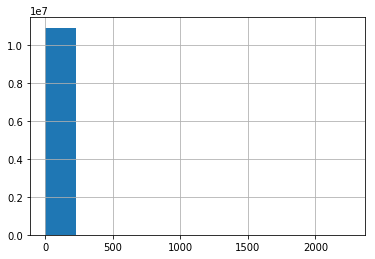

In [43]:
item_cnt = df_main[df_main.item_cnt_month>=0]['item_cnt_month']
item_cnt_plot_without_outliers = item_cnt.hist()

### Lets plot item count vs item category

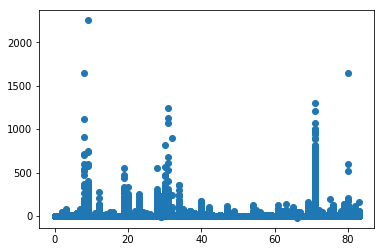

In [44]:
plt.scatter(df_main.item_category_id,df_main.item_cnt_month)
plt.show()

### there are few categories which are more in count than others

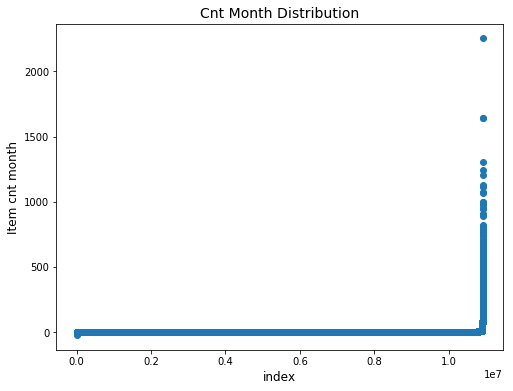

In [45]:
plt.figure(figsize=(8,6))
plt.scatter(range(df_main.shape[0]), np.sort(df_main['item_cnt_month'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Item cnt month', fontsize=12)
plt.title("Cnt Month Distribution", fontsize=14)
plt.show()

#### Most of the data set has 0 item_cnt_month value, few are zero and rest are greater than 0

### Category Wise distribution of item and its count

In [46]:
%load_ext autoreload
%autoreload 2

In [47]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

temp_cats = df_main['item_category_id'].value_counts()
labels = (np.array(temp_cats.index))
sizes = (np.array((temp_cats / temp_cats.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Category Distribution',
    width=900,
    height=900,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="Categories")

#### Clearly category no: 40, 55, 37 is more common than others

In [48]:
item_category[item_category['item_category_id'] == 40]

,item_category_name,item_category_id
40,Кино - DVD,40


#### translation: Кино - DVD -> Cinema - DVD

But what is item_month cnt for this category

In [49]:
df_main[df_main['item_category_id'] == 40]['item_cnt_month'].describe()

count    2.496236e+06
mean     2.540509e-01
std      1.372520e+00
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.750000e+02
Name: item_cnt_month, dtype: float64

In [50]:
df_main[df_main['item_category_id'] == 40]['item_cnt_month'].sum()

634171.0

In [51]:
df_main[df_main['item_category_id'] == 40]['item_cnt_month'].shape

(2496236,)

### what is count per date block

In [52]:
gr = df_main[df_main['item_category_id'] == 40].groupby(['date_block_num'])

In [53]:
gr['item_cnt_month'].sum()

date_block_num
0     33489.0
1     31649.0
2     36277.0
3     27525.0
4     25470.0
5     25992.0
6     24806.0
7     24130.0
8     23348.0
9     24173.0
10    25433.0
11    28598.0
12    22065.0
13    18467.0
14    21266.0
15    18320.0
16    15005.0
17    16064.0
18    14452.0
19    15821.0
20    12748.0
21    13639.0
22    14815.0
23    18876.0
24    15109.0
25    12100.0
26    13084.0
27    10683.0
28     9208.0
29     9304.0
30     9283.0
31     8513.0
32     6779.0
33     7680.0
Name: item_cnt_month, dtype: float64

#### The disk is actually getting sold a lot!!!

### How much our train and test intersect

In [54]:
data1 = df_main[['item_id', 'shop_id']].drop_duplicates()
data2 = test[['item_id', 'shop_id']].drop_duplicates()

In [55]:
data1 = data1["item_id"].map(str)+ "_" + data1["shop_id"].map(str)

In [56]:
data2 = data2["item_id"].map(str)+ "_" + data2["shop_id"].map(str)

In [57]:
data1.head()

0    22154_59
1     2552_59
2     2554_59
3     2555_59
4     2564_59
dtype: object

In [58]:
data2.head()

0    5037_5
1    5320_5
2    5233_5
3    5232_5
4    5268_5
dtype: object

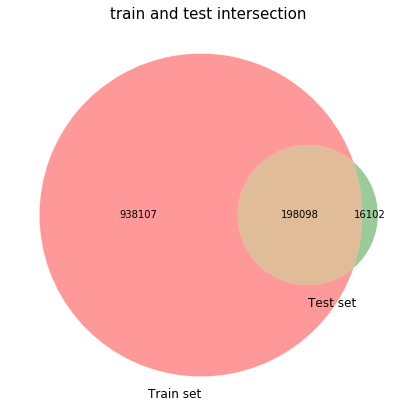

In [59]:
from matplotlib_venn import venn2

plt.figure(figsize=(10,7))
venn2([set(data1), set(data2)], set_labels = ('Train set', 'Test set') )
plt.title("train and test intersection", fontsize=15)
plt.show()

#### Good most of the test data is in train set

### Prepare the data for training

In [60]:
df_test = test.copy()

### Prepare the test data

In [61]:
df_test['date_block_num'] = 34
df_test.drop('ID', axis=1, inplace=True)

df_test = df_test.merge(item, how='left', on='item_id')
df_test.drop('item_name', axis=1, inplace=True)

In [62]:
df_combined = pd.concat([df_main,df_test], axis=0, ignore_index=True)

In [63]:
df_combined.isnull().sum()

date_block_num           0
item_category_id         0
item_cnt_month      214200
item_id                  0
item_price          214200
shop_id                  0
dtype: int64

### Mean Encoding

Please note I a have referred mean encoding from here: http://mlwhiz.com/blog/2017/12/26/How_to_win_a_data_science_competition/

In [64]:
for type_id in ['item_id','shop_id','item_category_id']:
    for column_id, agg_func, func_name in [('item_price',np.mean,'avg'),('item_cnt_month',np.sum,'sum'),('item_cnt_month',np.mean,'avg')]:

        mean_df = df_main.groupby([type_id,'date_block_num']).agg(agg_func).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+func_name+'_'+column_id, type_id,'date_block_num']
        
        df_main = pd.merge(df_main,mean_df,on=['date_block_num', type_id],how='left')

In [65]:
df_main.isnull().sum()

shop_id                                0
item_id                                0
date_block_num                         0
item_cnt_month                         0
item_price                             0
item_category_id                       0
item_id_avg_item_price                 0
item_id_sum_item_cnt_month             0
item_id_avg_item_cnt_month             0
shop_id_avg_item_price                 0
shop_id_sum_item_cnt_month             0
shop_id_avg_item_cnt_month             0
item_category_id_avg_item_price        0
item_category_id_sum_item_cnt_month    0
item_category_id_avg_item_cnt_month    0
dtype: int64

In [66]:
df_main = pd.concat([df_main,df_test], axis=0, ignore_index=True)

In [67]:
df_main.isnull().sum()

date_block_num                              0
item_category_id                            0
item_category_id_avg_item_cnt_month    214200
item_category_id_avg_item_price        214200
item_category_id_sum_item_cnt_month    214200
item_cnt_month                         214200
item_id                                     0
item_id_avg_item_cnt_month             214200
item_id_avg_item_price                 214200
item_id_sum_item_cnt_month             214200
item_price                             214200
shop_id                                     0
shop_id_avg_item_cnt_month             214200
shop_id_avg_item_price                 214200
shop_id_sum_item_cnt_month             214200
dtype: int64

### Implemented lag variable

I used lag variable till 2 because I have only 16GB ram

In [68]:
lag_variables  = ['item_id_avg_item_price', 'item_id_sum_item_cnt_month', 
                  'item_id_avg_item_cnt_month', 'shop_id_avg_item_price', 
                  'shop_id_sum_item_cnt_month', 'shop_id_avg_item_cnt_month',
                  'item_category_id_avg_item_price', 'item_category_id_sum_item_cnt_month',
                  'item_category_id_avg_item_cnt_month', 'item_cnt_month']

lags = [1 ,2]

for lag in lags:
    df_main_new = df_main.copy()
    df_main_new.date_block_num+=lag
    df_main_new = df_main_new[['date_block_num','shop_id','item_id']+lag_variables]
    df_main_new.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    df_main = pd.merge(df_main, df_main_new,on=['date_block_num','shop_id','item_id'] ,how='left')

### Fill the null values

In [69]:
for feat in df_main.columns:
    if 'item_cnt' in feat:
        df_main[feat]=df_main[feat].fillna(0)
    elif 'item_price' in feat:
        df_main[feat]=df_main[feat].fillna(df_main[feat].median())

In [71]:
df_main.columns

Index(['date_block_num', 'item_category_id',
       'item_category_id_avg_item_cnt_month',
       'item_category_id_avg_item_price',
       'item_category_id_sum_item_cnt_month', 'item_cnt_month', 'item_id',
       'item_id_avg_item_cnt_month', 'item_id_avg_item_price',
       'item_id_sum_item_cnt_month', 'item_price', 'shop_id',
       'shop_id_avg_item_cnt_month', 'shop_id_avg_item_price',
       'shop_id_sum_item_cnt_month', 'item_id_avg_item_price_lag_1',
       'item_id_sum_item_cnt_month_lag_1', 'item_id_avg_item_cnt_month_lag_1',
       'shop_id_avg_item_price_lag_1', 'shop_id_sum_item_cnt_month_lag_1',
       'shop_id_avg_item_cnt_month_lag_1',
       'item_category_id_avg_item_price_lag_1',
       'item_category_id_sum_item_cnt_month_lag_1',
       'item_category_id_avg_item_cnt_month_lag_1', 'item_cnt_month_lag_1',
       'item_id_avg_item_price_lag_2', 'item_id_sum_item_cnt_month_lag_2',
       'item_id_avg_item_cnt_month_lag_2', 'shop_id_avg_item_price_lag_2',
       'shop

In [72]:
drop_cols = lag_variables[:-1] + ['item_price']

In [73]:
x_train = df_main[df_main['date_block_num'] < 33].drop(drop_cols, axis=1)
x_cv =  df_main[df_main['date_block_num'] == 33].drop(drop_cols, axis=1)
x_test = df_main[df_main['date_block_num'] == 34].drop(drop_cols, axis=1)

In [76]:
x_train['item_cnt_month'].clip(0, 40, inplace=True)
x_cv['item_cnt_month'].clip(0, 40, inplace=True)
x_test['item_cnt_month'].clip(0, 40, inplace=True)

In [77]:
x_train.to_csv('train_with_lag.csv', index=False)
x_cv.to_csv('cv_with_lag.csv', index=False)
x_test.to_csv('test_with_lag.csv', index=False)

In [83]:
x_train.isnull().sum()

date_block_num                               0
item_category_id                             0
item_cnt_month                               0
item_id                                      0
shop_id                                      0
item_id_avg_item_price_lag_1                 0
item_id_sum_item_cnt_month_lag_1             0
item_id_avg_item_cnt_month_lag_1             0
shop_id_avg_item_price_lag_1                 0
shop_id_sum_item_cnt_month_lag_1             0
shop_id_avg_item_cnt_month_lag_1             0
item_category_id_avg_item_price_lag_1        0
item_category_id_sum_item_cnt_month_lag_1    0
item_category_id_avg_item_cnt_month_lag_1    0
item_cnt_month_lag_1                         0
item_id_avg_item_price_lag_2                 0
item_id_sum_item_cnt_month_lag_2             0
item_id_avg_item_cnt_month_lag_2             0
shop_id_avg_item_price_lag_2                 0
shop_id_sum_item_cnt_month_lag_2             0
shop_id_avg_item_cnt_month_lag_2             0
item_category

In [29]:
test = pd.read_csv('test.csv')
x_train = pd.read_csv('train_with_lag.csv')
x_cv = pd.read_csv('cv_with_lag.csv')
x_test = pd.read_csv('test_with_lag.csv')

In [5]:
cols = [x for x in x_train.columns if x != "item_cnt_month"]
print(cols)

['date_block_num', 'item_category_id', 'item_id', 'shop_id', 'item_id_avg_item_price_lag_1', 'item_id_sum_item_cnt_month_lag_1', 'item_id_avg_item_cnt_month_lag_1', 'shop_id_avg_item_price_lag_1', 'shop_id_sum_item_cnt_month_lag_1', 'shop_id_avg_item_cnt_month_lag_1', 'item_category_id_avg_item_price_lag_1', 'item_category_id_sum_item_cnt_month_lag_1', 'item_category_id_avg_item_cnt_month_lag_1', 'item_cnt_month_lag_1', 'item_id_avg_item_price_lag_2', 'item_id_sum_item_cnt_month_lag_2', 'item_id_avg_item_cnt_month_lag_2', 'shop_id_avg_item_price_lag_2', 'shop_id_sum_item_cnt_month_lag_2', 'shop_id_avg_item_cnt_month_lag_2', 'item_category_id_avg_item_price_lag_2', 'item_category_id_sum_item_cnt_month_lag_2', 'item_category_id_avg_item_cnt_month_lag_2', 'item_cnt_month_lag_2']


In [6]:
params = {
        'eta': 0.08,
        'max_depth': 8,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'seed': 3,
        'gamma':1
    }

In [7]:
import xgboost as xgb
x1 = x_train[cols]
y1 = x_train['item_cnt_month']
x2 = x_cv[cols]
y2 = x_cv['item_cnt_month']
tr = xgb.DMatrix(x1, y1)
val = xgb.DMatrix(x2, y2)


watchlist = [(tr, 'train'), (val, 'valid')]
model = xgb.train(params, 
                  tr, 
                  4000,  
                  watchlist, 
                  maximize=False, 
                  verbose_eval=50, 
                  early_stopping_rounds=100)

/home/shrishty/.conda/envs/tf/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[0]	train-rmse:1.45032	valid-rmse:1.37951
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[50]	train-rmse:1.10742	valid-rmse:1.14456
[100]	train-rmse:1.07386	valid-rmse:1.13898
[150]	train-rmse:1.05201	valid-rmse:1.14149
[200]	train-rmse:1.03695	valid-rmse:1.14246
Stopping. Best iteration:
[107]	train-rmse:1.0709	valid-rmse:1.13862



### On submission: I scored 0.98076 in public leader board 

In [10]:
best_model = model.best_ntree_limit

In [12]:
pred = model.predict(xgb.DMatrix(x_test[cols]), 
                     ntree_limit=best_model)

test['item_cnt_month'] = pred.clip(0,20)
# test.drop(['shop_id', 'item_id'], axis=1, inplace=True)
test.to_csv('sub2.csv', index=False)

In [13]:
test.head()

,ID,item_cnt_month
0,0,0.433765
1,1,0.092590
2,2,0.948186
3,3,0.370803
4,4,3.062373


In [16]:
model.save_model('0001.model')